In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import f1_score as f1_score_func
from sklearn.metrics import accuracy_score


from sklearn.metrics import classification_report
from plotingfun import *
from helper_functions import *
import scipy.io as io
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA




Some pre prosses to help us improve model training speed

In [2]:

mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5


Loading the data

In [3]:
data=io.loadmat("Data/WLDataCW.mat")

In [4]:
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Fri Jan 21 21:10:34 2022',
 '__version__': '1.0',
 '__globals__': [],
 'data': array([[[ 3.64516091e+00, -1.22507811e+00,  8.41415691e+00, ...,
          -1.16731644e+01,  2.65084229e+01,  4.00945067e-01],
         [ 1.57700694e+00,  2.68786597e+00,  2.37991428e+00, ...,
          -9.80385399e+00,  2.95700607e+01,  1.86778176e+00],
         [-2.88467383e+00,  3.47892046e+00, -3.33852053e+00, ...,
          -7.33824921e+00,  3.09278240e+01,  2.78261375e+00],
         ...,
         [ 6.32441854e+00,  7.38758564e+00, -5.30264425e+00, ...,
           2.92871971e+01, -2.80428171e-01, -4.32558784e+01],
         [-5.14494121e-01,  1.25400152e+01, -2.38987041e+00, ...,
           2.50036125e+01, -1.41281223e+00, -3.64643059e+01],
         [-3.36245584e+00,  1.25796471e+01,  1.27706754e+00, ...,
           2.42137814e+01, -1.03876221e+00, -3.15475597e+01]],
 
        [[ 1.40172338e+01,  6.67675018e+00,  1.04504976e+01, ...,
   

In [5]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'data', 'label'])

In [6]:
X=data['data']

In [7]:
y=data['label']

In [8]:
X,y

(array([[[ 3.64516091e+00, -1.22507811e+00,  8.41415691e+00, ...,
          -1.16731644e+01,  2.65084229e+01,  4.00945067e-01],
         [ 1.57700694e+00,  2.68786597e+00,  2.37991428e+00, ...,
          -9.80385399e+00,  2.95700607e+01,  1.86778176e+00],
         [-2.88467383e+00,  3.47892046e+00, -3.33852053e+00, ...,
          -7.33824921e+00,  3.09278240e+01,  2.78261375e+00],
         ...,
         [ 6.32441854e+00,  7.38758564e+00, -5.30264425e+00, ...,
           2.92871971e+01, -2.80428171e-01, -4.32558784e+01],
         [-5.14494121e-01,  1.25400152e+01, -2.38987041e+00, ...,
           2.50036125e+01, -1.41281223e+00, -3.64643059e+01],
         [-3.36245584e+00,  1.25796471e+01,  1.27706754e+00, ...,
           2.42137814e+01, -1.03876221e+00, -3.15475597e+01]],
 
        [[ 1.40172338e+01,  6.67675018e+00,  1.04504976e+01, ...,
          -7.23842859e+00,  2.92477169e+01, -6.11521196e+00],
         [ 9.57320786e+00,  1.03044224e+01,  4.34053040e+00, ...,
          -4.79710388

In [9]:
classes=["Low Workload","Medium Workload"]

In [10]:
X.shape,y.shape

((62, 512, 360), (1, 360))

In [11]:
X=X.T
y=y.T

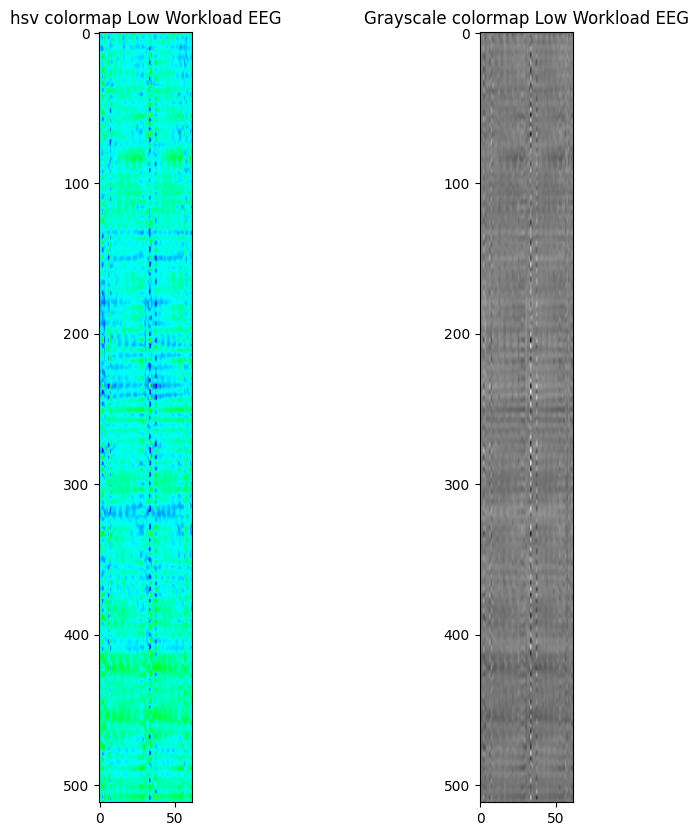

In [12]:
import matplotlib.pyplot as plt
import numpy as np

rand = np.random.randint(0, 287)
fig, axs = plt.subplots(1, 2, figsize=(9, 10))

# Get the class index by converting y_train[rand] to an integer
class_index = int(y[rand])

# Plot the first image with hsv colormap
axs[0].imshow(X[rand], cmap='hsv')
axs[0].set_title(f'hsv colormap {classes[class_index]} EEG')
# Plot the same image with grayscale colormap
axs[1].imshow(X[rand], cmap='gray')
axs[1].set_title(f'Grayscale colormap {classes[class_index]} EEG')

plt.show()


In [13]:
log="tensorbord"

Logistic Model

In [14]:
class LogisticRegression:
    def __init__(self, lr, input, label, max_loss, max_num_of_iter,hidden_size,test_data):
        self.lr = lr
        self.input = input
        self.label = label
        self.test_data=test_data
        # Xavier initialization of weights
        self.hidden_size=hidden_size
        self.weights1 = np.random.randn(self.input.shape[1],self.hidden_size) * np.sqrt(1 / input.shape[1])#10 is number of neuron # 31744 is number of features
        self.bias1 = np.zeros((1,self.hidden_size))
        self.weights2 = np.random.randn(self.hidden_size,1) * np.sqrt(1 / input.shape[1])
        self.bias2 = np.zeros((1, 1))
        self.max_num_of_iter = max_num_of_iter
        self.max_loss = max_loss

    def sigmoid_activation(self, layer):
        sigmoid = 1 / (1 + np.exp(-layer))
        return sigmoid

    def forward_propagation(self):
        l1 = np.dot(self.input,self.weights1)+self.bias1
        output_activation1 = self.sigmoid_activation(l1)
        l2 = np.dot(output_activation1,self.weights2) + self.bias2
        output_activation2 = self.sigmoid_activation(l2)
        return output_activation1, output_activation2

    def log_loss(self,output_activation2):
        log_loss=-1/len(self.label)*np.sum(self.label*np.log(output_activation2)+(1-self.label)*np.log(1-output_activation2))
        return log_loss

    def backward_propagation(self, output_activation1, output_activation2):
        doutput = output_activation2 - self.label
        dhidden = np.dot(doutput,self.weights2.T) * output_activation1 * (1 - output_activation1)
        return doutput, dhidden

    def update_params(self, output_activation1, doutput, dhidden):
        self.weights2 -= self.lr * np.dot(output_activation1.T, doutput)
        self.bias2 -= self.lr * np.sum(doutput, axis=0, keepdims=True)
        self.weights1 -= self.lr * np.dot(self.input.T, dhidden)
        self.bias1 -= self.lr * np.sum(dhidden, axis=0, keepdims=True)
        return self.weights2, self.bias2, self.weights1, self.bias1

    def train(self):
        num_of_iter = 0
        lossplt=[]
        while num_of_iter < self.max_num_of_iter:
            output_activation1, output_activation2 = self.forward_propagation()
            loss = self.log_loss(output_activation2)
            doutput, dhidden = self.backward_propagation(output_activation1, output_activation2)
            self.update_params(output_activation1, doutput, dhidden)
            num_of_iter += 1
            # Print the loss every 100 epochs
            if num_of_iter % 100 == 0:
                print("Epoch {}: Loss = {}".format(num_of_iter, loss))
                lossplt.append(loss)

        # Return the weights and biases for the hidden and output layers
        import matplotlib.pyplot as plt
        plt.plot(lossplt)
        return self.weights1, self.bias1, self.weights2, self.bias2
    def predict(self):
        # Forward propagation is only needed as we are not going to update weights
        l1 = np.dot(self.test_data, self.weights1) + self.bias1
        output_activation1=self.sigmoid_activation(l1)
        l2 = np.dot(output_activation1, self.weights2) + self.bias2
        output_activation2=self.sigmoid_activation(l2)
        # Round the output to 0 or 1
        predictions = np.round(output_activation2)

        return predictions


In [15]:
def preprosess_data(data):
    #Coverting The image data to 2d tensor by reducing 1 dimention
    data = data.reshape((data.shape[0], -1))
    #Scaling Image
    data=data/255.
    return data
X_logistic=preprosess_data(X)
pca = PCA(n_components=None)
X_logistic = pca.fit_transform(X_logistic)



In [16]:
Crossvalidation = KFold(n_splits=5, shuffle=True, random_state=42)

Epoch 100: Loss = 0.014983640963758343
Epoch 200: Loss = 0.004405012411783861
Epoch 300: Loss = 0.002435228556174951
Epoch 400: Loss = 0.0016486232749524754
Epoch 500: Loss = 0.0012331960482166752
Epoch 600: Loss = 0.0009788739775137075
Epoch 700: Loss = 0.0008081916877249706
Epoch 800: Loss = 0.0006862093543117897
Epoch 900: Loss = 0.0005949497399382549
Epoch 1000: Loss = 0.0005242564824593637
Epoch 100: Loss = 0.015884494845803242
Epoch 200: Loss = 0.00479797365858134
Epoch 300: Loss = 0.0026742780107691763
Epoch 400: Loss = 0.0018177401155268478
Epoch 500: Loss = 0.0013631039691007233
Epoch 600: Loss = 0.0010837631773538685
Epoch 700: Loss = 0.000895622519020771
Epoch 800: Loss = 0.0007605584111416471
Epoch 900: Loss = 0.0006588499025359517
Epoch 1000: Loss = 0.0005794144755633234
Epoch 100: Loss = 0.017952872917362524
Epoch 200: Loss = 0.00498283068879701
Epoch 300: Loss = 0.0027141474537517953
Epoch 400: Loss = 0.0018269469461878647
Epoch 500: Loss = 0.0013627307093272256
Epoch 60

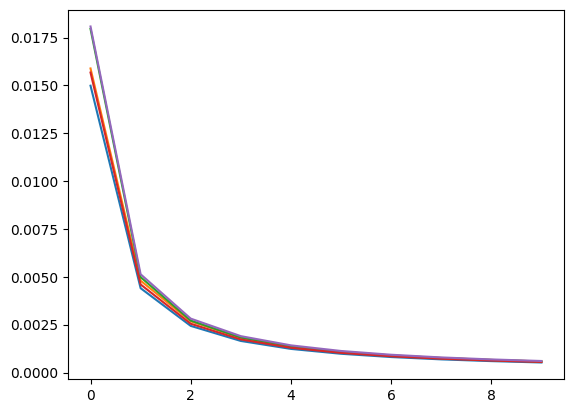

In [17]:
accuracy_scores = []
f1_scores_list = []
recall_scores = []
precision_scores_list = []

crossvalidation = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in crossvalidation.split(X_logistic):
    X_train, X_test = X_logistic[train_index], X_logistic[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = LogisticRegression(lr=0.01, input=X_train, label=y_train, max_loss=0.5, max_num_of_iter=1000, hidden_size=10, test_data=X_test)
    weights1, bias1, weights2, bias2 = model.train()
    y_pred = model.predict()
    accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
    accuracy_scores.append(accuracy)
    f1 = f1_score_func(y_true=y_test, y_pred=y_pred, average='binary')
    f1_scores_list.append(f1)
    recall = recall_score(y_true=y_test, y_pred=y_pred, average='binary')
    recall_scores.append(recall)
    precision = precision_score(y_true=y_test, y_pred=y_pred, average='binary')
    precision_scores_list.append(precision)

mean_accuracy = np.mean(accuracy_scores)
mean_f1 = np.mean(f1_scores_list)
mean_recall = np.mean(recall_scores)
mean_precision = np.mean(precision_scores_list)

log_model_score = {"Accuracy": mean_accuracy, "F1-Score": mean_f1, "Recall": mean_recall, "Precision": mean_precision}


In [18]:
log_model_score

{'Accuracy': 0.5055555555555555,
 'F1-Score': 0.5682325896092932,
 'Recall': 0.6522086466165413,
 'Precision': 0.5087738670347366}

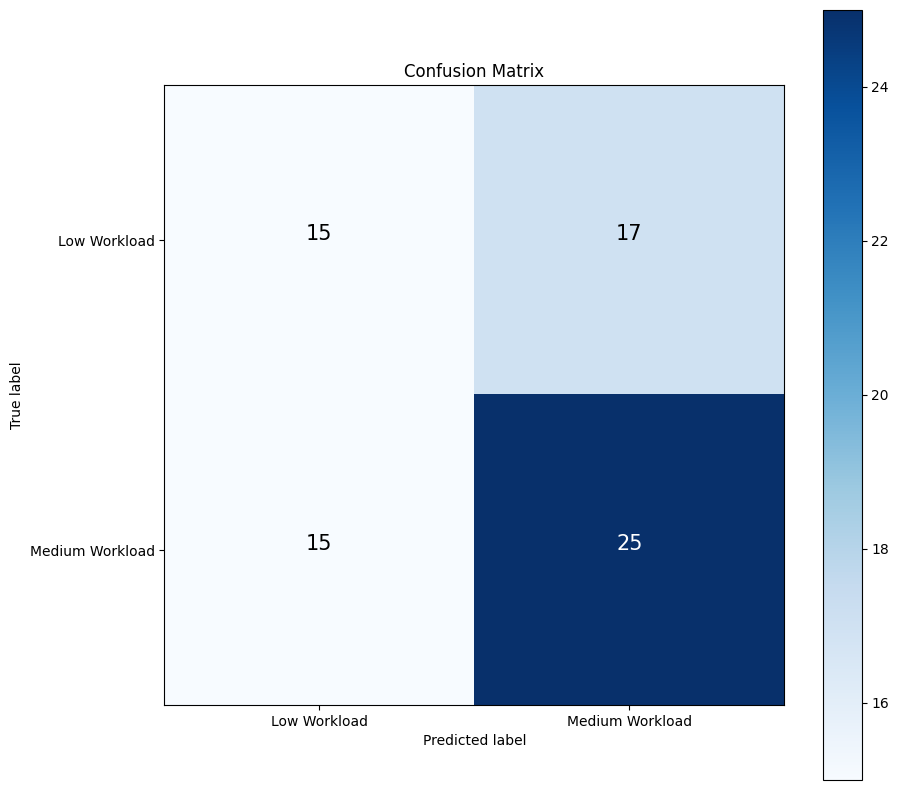

In [19]:
make_confusion_matrix(y_true=y_test,y_pred=y_pred,classes=classes)

In [20]:
clf_report=classification_report(y_pred=y_pred,y_true=y_test,
                                   output_dict=True,target_names=classes)
clf_report=pd.DataFrame(clf_report)
clf_report

,Low Workload,Medium Workload,accuracy,macro avg,weighted avg
precision,0.500000,0.595238,0.555556,0.547619,0.552910
recall,0.468750,0.625000,0.555556,0.546875,0.555556
f1-score,0.483871,0.609756,0.555556,0.546814,0.553807
support,32.000000,40.000000,0.555556,72.000000,72.000000


<AxesSubplot: >

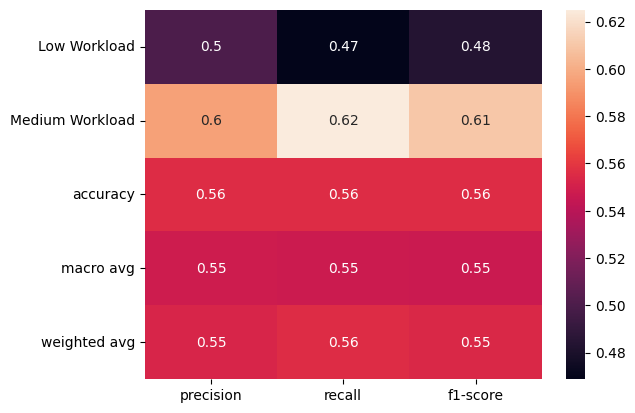

In [21]:
sns.heatmap(clf_report.iloc[:-1, :].T, annot=True)

CNN Model

In [22]:
accuracy_scores = []
f1_scores_list = []
recall_scores = []
precision_scores_list = []

crossvalidation = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in crossvalidation.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #model
    input_layer = tf.keras.Input(shape=(512, 62, 1),name="input_layer")
    Conv2D_layer_1 = tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu",name="Conv2D_layer1")(input_layer)
    Conv2D_layer_2 = tf.keras.layers.Conv2D(10, 3, activation="relu",name="Conv2D_layer_2")(Conv2D_layer_1)
    MaxPooling2D_layer_1 = tf.keras.layers.MaxPooling2D(pool_size=2, padding="valid",name="MaxPooling2D_layer_1")(Conv2D_layer_2)
    Conv2D_layer_3= tf.keras.layers.Conv2D(10, 3, activation="relu",name="Conv2D_layer_3")(MaxPooling2D_layer_1)
    Conv2D_layer_4 = tf.keras.layers.Conv2D(10, 3, activation="relu",name="Conv2D_layer_4")(Conv2D_layer_3)
    MaxPooling2D_layer_2 = tf.keras.layers.MaxPooling2D(2,name="MaxPooling2D_layer_2")(Conv2D_layer_4)
    Flattening_layer = tf.keras.layers.Flatten(name="Flattening_layer")(MaxPooling2D_layer_2)
    Dense_layer_1 = tf.keras.layers.Dense(32, activation="relu",name="Dense_layer_1")(Flattening_layer)
    Dense_layer_2 = tf.keras.layers.Dense(64, activation="relu",name="Dense_layer_2")(Dense_layer_1)
    Dense_layer_3 = tf.keras.layers.Dense(128, activation="relu",name="Dense_layer_3")(Dense_layer_2)
    output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(Dense_layer_3)
    cnn_model = tf.keras.Model(inputs=input_layer, outputs=output_layer,name="cnn_model")
    # 2 compile the model
    cnn_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

    #3 fitting
    history1=cnn_model.fit(X_train, y_train, epochs=1000,validation_data=[X_test,y_test],callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=100,restore_best_weights=True),
    create_tensorboard_callback(cnn_model.name,log)])
    #evaluating
    y_pred = np.round(cnn_model.predict(X_test))
    accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
    accuracy_scores.append(accuracy)
    f1 = f1_score_func(y_true=y_test, y_pred=y_pred, average='binary')
    f1_scores_list.append(f1)
    recall = recall_score(y_true=y_test, y_pred=y_pred, average='binary')
    recall_scores.append(recall)
    precision = precision_score(y_true=y_test, y_pred=y_pred, average='binary')
    precision_scores_list.append(precision)

mean_accuracy = np.mean(accuracy_scores)
mean_f1 = np.mean(f1_scores_list)
mean_recall = np.mean(recall_scores)
mean_precision = np.mean(precision_scores_list)

cnn_model_score = {"Accuracy": mean_accuracy, "F1-Score": mean_f1, "Recall": mean_recall, "Precision": mean_precision}


Saving TensorBoard log files to: cnn_model/tensorbord/20230329-192242
Epoch 1/1000
9/9 [==============================] - 4s 81ms/step - loss: 3.2434 - accuracy: 0.4965 - val_loss: 1.0240 - val_accuracy: 0.4861
Epoch 2/1000
9/9 [==============================] - 0s 48ms/step - loss: 0.8058 - accuracy: 0.5174 - val_loss: 0.6522 - val_accuracy: 0.5139
Epoch 3/1000
9/9 [==============================] - 0s 48ms/step - loss: 0.6116 - accuracy: 0.7465 - val_loss: 0.5337 - val_accuracy: 0.8750
Epoch 4/1000
9/9 [==============================] - 0s 47ms/step - loss: 0.4730 - accuracy: 0.8681 - val_loss: 0.4046 - val_accuracy: 0.9028
Epoch 5/1000
9/9 [==============================] - 0s 46ms/step - loss: 0.3223 - accuracy: 0.9062 - val_loss: 0.3254 - val_accuracy: 0.9028
Epoch 6/1000
9/9 [==============================] - 0s 48ms/step - loss: 0.2729 - accuracy: 0.9097 - val_loss: 0.2886 - val_accuracy: 0.9167
Epoch 7/1000
9/9 [==============================] - 0s 48ms/step - loss: 0.1689 - ac

In [23]:
accuracy_scores

[0.9166666666666666,
 0.8888888888888888,
 0.9166666666666666,
 0.9444444444444444,
 0.8888888888888888]

In [24]:
cnn_model_score

{'Accuracy': 0.9111111111111111,
 'F1-Score': 0.9083954203691045,
 'Recall': 0.8797556390977442,
 'Precision': 0.9404604529984036}

In [25]:
# checking wheather mixed pressison is working or not
for layer in cnn_model.layers:
    print(layer.name,layer.dtype,layer.dtype_policy,layer.trainable)

input_layer float32 <Policy "float32"> True
Conv2D_layer1 float32 <Policy "mixed_float16"> True
Conv2D_layer_2 float32 <Policy "mixed_float16"> True
MaxPooling2D_layer_1 float32 <Policy "mixed_float16"> True
Conv2D_layer_3 float32 <Policy "mixed_float16"> True
Conv2D_layer_4 float32 <Policy "mixed_float16"> True
MaxPooling2D_layer_2 float32 <Policy "mixed_float16"> True
Flattening_layer float32 <Policy "mixed_float16"> True
Dense_layer_1 float32 <Policy "mixed_float16"> True
Dense_layer_2 float32 <Policy "mixed_float16"> True
Dense_layer_3 float32 <Policy "mixed_float16"> True
dense_4 float32 <Policy "mixed_float16"> True


In [26]:
cnn_model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 512, 62, 1)]      0         
                                                                 
 Conv2D_layer1 (Conv2D)      (None, 510, 60, 10)       100       
                                                                 
 Conv2D_layer_2 (Conv2D)     (None, 508, 58, 10)       910       
                                                                 
 MaxPooling2D_layer_1 (MaxPo  (None, 254, 29, 10)      0         
 oling2D)                                                        
                                                                 
 Conv2D_layer_3 (Conv2D)     (None, 252, 27, 10)       910       
                                                                 
 Conv2D_layer_4 (Conv2D)     (None, 250, 25, 10)       910       
                                                         

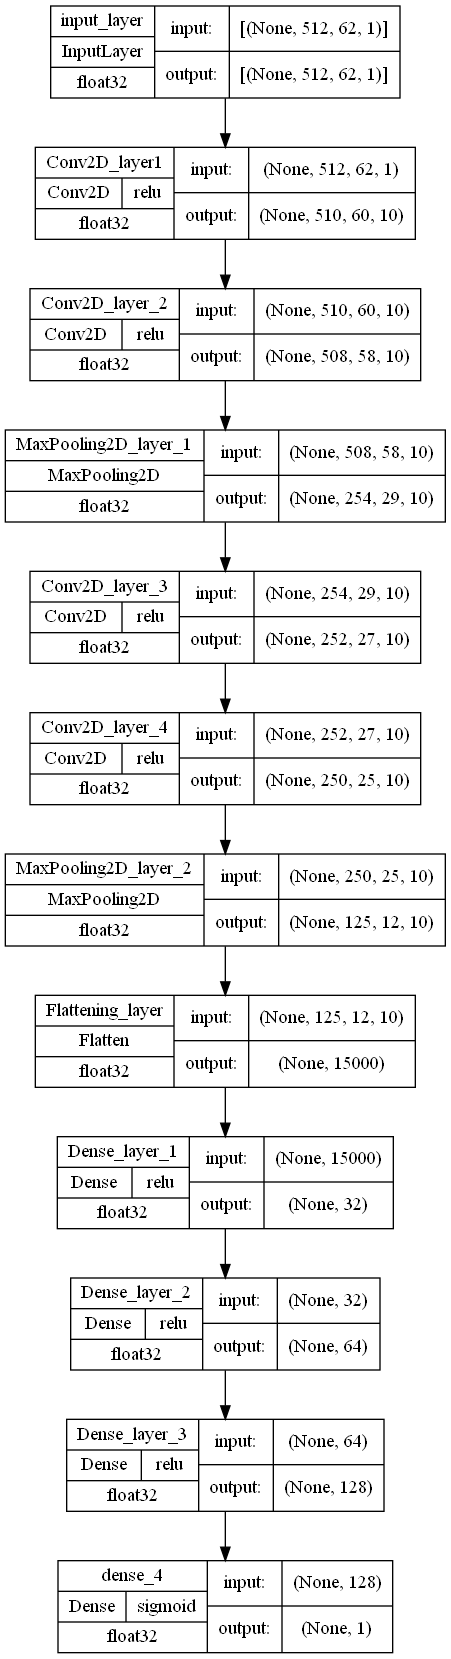

In [27]:
plot_model(cnn_model,show_dtype=True,show_layer_activations=True,show_shapes=True)

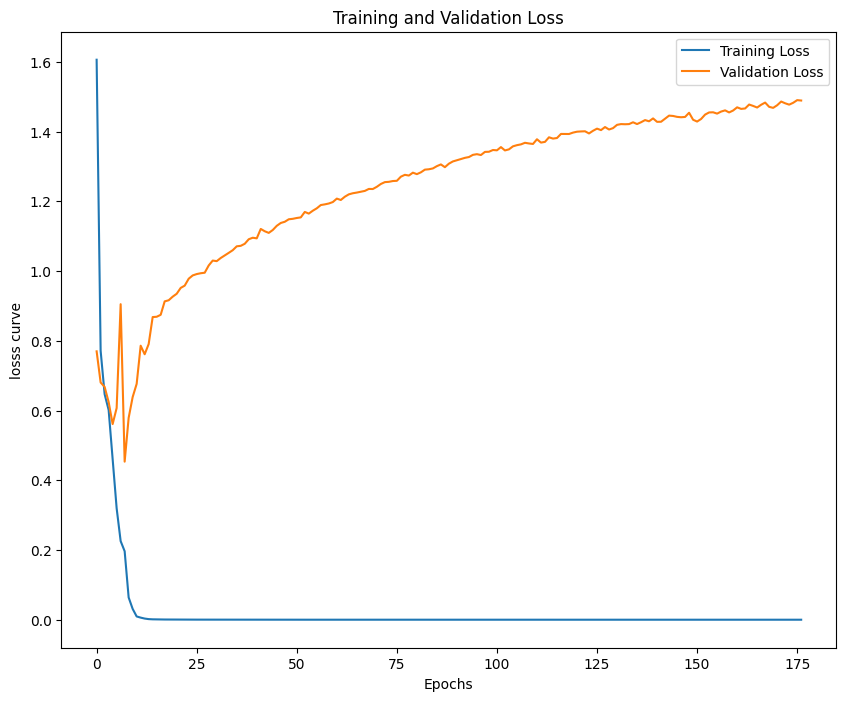

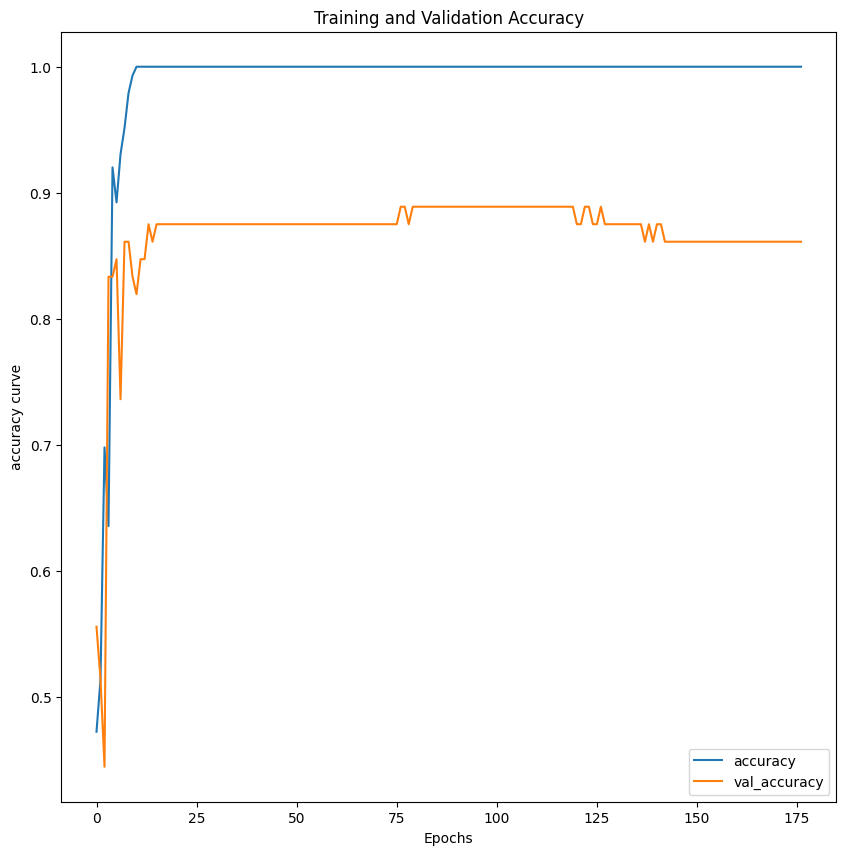

In [28]:
loss(history1)

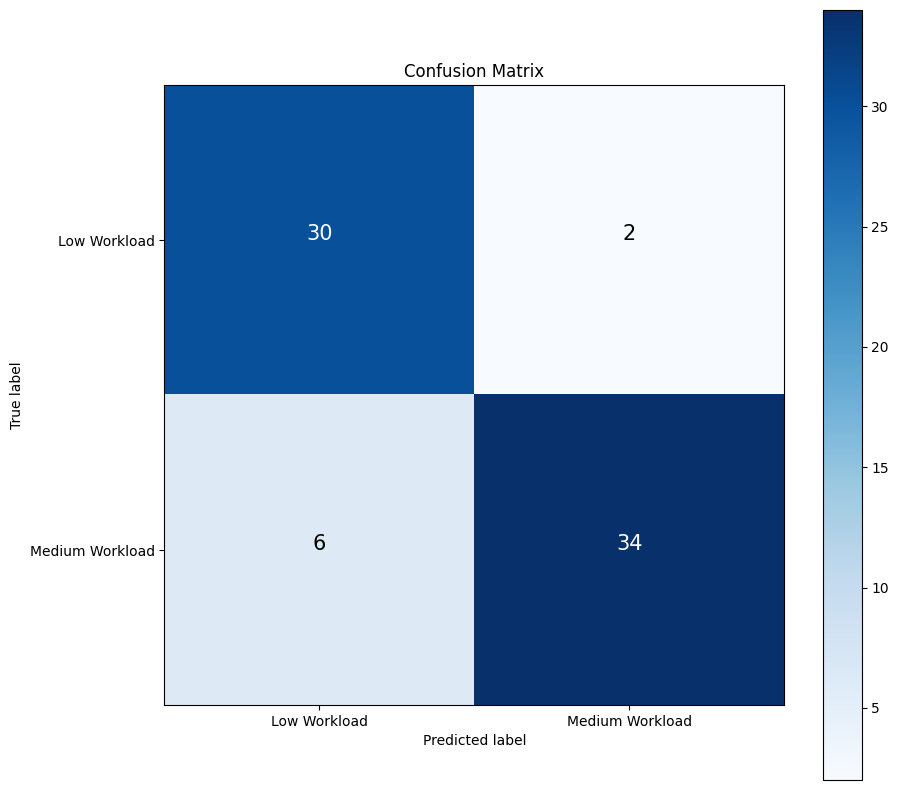

In [29]:
make_confusion_matrix(y_true=y_test,y_pred=y_pred,classes=classes)

In [30]:
clf_report=classification_report(y_pred=y_pred,y_true=y_test,
                                   output_dict=True,target_names=classes)
clf_report=pd.DataFrame(clf_report)
clf_report

,Low Workload,Medium Workload,accuracy,macro avg,weighted avg
precision,0.833333,0.944444,0.888889,0.888889,0.895062
recall,0.937500,0.850000,0.888889,0.893750,0.888889
f1-score,0.882353,0.894737,0.888889,0.888545,0.889233
support,32.000000,40.000000,0.888889,72.000000,72.000000


<AxesSubplot: >

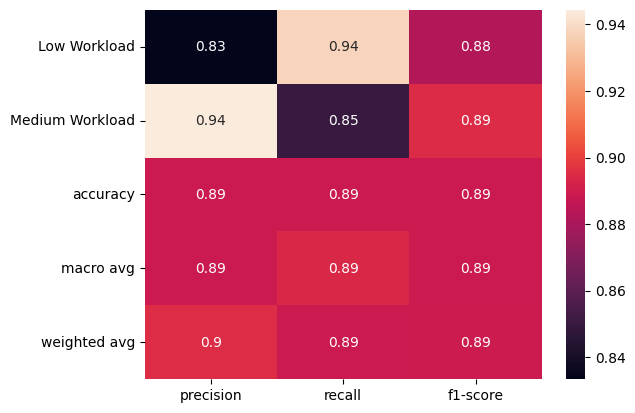

In [31]:
sns.heatmap(clf_report.iloc[:-1, :].T, annot=True)

LSTM model

In [32]:
accuracy_scores = []
f1_scores_list = []
recall_scores = []
precision_scores_list = []

crossvalidation = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in crossvalidation.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #1 model archi
    input_layer=tf.keras.layers.Input(shape=(512,62),name="Input_Layer")
    lstm_layer1=tf.keras.layers.LSTM(100,return_sequences=True,activation="tanh")(input_layer)
    lstm_layer2=tf.keras.layers.LSTM(100,activation="tanh")(lstm_layer1)
    output_layer=tf.keras.layers.Dense(1,activation="sigmoid")(lstm_layer2)
    lstm_model=tf.keras.Model(inputs=input_layer,outputs=output_layer,name="lstm_model")
    # 2 compile the model
    lstm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

    #3 fitting our model
    history2=lstm_model.fit(X_train, y_train, epochs=1000,validation_data=[X_test,y_test],
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=100,restore_best_weights=True),
    create_tensorboard_callback(lstm_model.name,log)])

    # 4 evaluating our model
    y_pred = np.round(lstm_model.predict(X_test))
    accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
    accuracy_scores.append(accuracy)
    f1 = f1_score_func(y_true=y_test, y_pred=y_pred, average='binary')
    f1_scores_list.append(f1)
    recall = recall_score(y_true=y_test, y_pred=y_pred, average='binary')
    recall_scores.append(recall)
    precision = precision_score(y_true=y_test, y_pred=y_pred, average='binary')
    precision_scores_list.append(precision)

mean_accuracy = np.mean(accuracy_scores)
mean_f1 = np.mean(f1_scores_list)
mean_recall = np.mean(recall_scores)
mean_precision = np.mean(precision_scores_list)

lstm_model_score = {"Accuracy": mean_accuracy, "F1-Score": mean_f1, "Recall": mean_recall, "Precision": mean_precision}


Saving TensorBoard log files to: lstm_model/tensorbord/20230329-192710
Epoch 1/1000
9/9 [==============================] - 5s 245ms/step - loss: 0.6672 - accuracy: 0.6354 - val_loss: 0.6442 - val_accuracy: 0.6944
Epoch 2/1000
9/9 [==============================] - 1s 152ms/step - loss: 0.4705 - accuracy: 0.8646 - val_loss: 0.5967 - val_accuracy: 0.7500
Epoch 3/1000
9/9 [==============================] - 1s 151ms/step - loss: 0.2634 - accuracy: 0.9306 - val_loss: 0.5503 - val_accuracy: 0.7917
Epoch 4/1000
9/9 [==============================] - 1s 162ms/step - loss: 0.1357 - accuracy: 0.9583 - val_loss: 0.6523 - val_accuracy: 0.7917
Epoch 5/1000
9/9 [==============================] - 1s 153ms/step - loss: 0.1046 - accuracy: 0.9653 - val_loss: 0.6243 - val_accuracy: 0.8194
Epoch 6/1000
9/9 [==============================] - 1s 160ms/step - loss: 0.1060 - accuracy: 0.9653 - val_loss: 0.4958 - val_accuracy: 0.8194
Epoch 7/1000
9/9 [==============================] - 1s 154ms/step - loss: 0.0

In [33]:
accuracy_scores

[0.875, 0.9444444444444444, 0.8611111111111112, 0.9166666666666666, 0.875]

In [34]:
lstm_model_score

{'Accuracy': 0.8944444444444443,
 'F1-Score': 0.895769968593498,
 'Recall': 0.9040507518796993,
 'Precision': 0.8919303757539051}

In [35]:
lstm_model.summary()

Model: "lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 512, 62)]         0         
                                                                 
 lstm_8 (LSTM)               (None, 512, 100)          65200     
                                                                 
 lstm_9 (LSTM)               (None, 100)               80400     
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 145,701
Trainable params: 145,701
Non-trainable params: 0
_________________________________________________________________


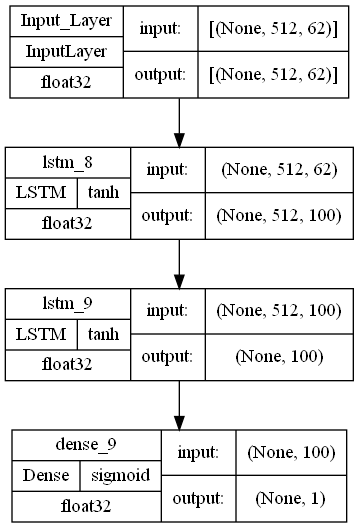

In [36]:
plot_model(lstm_model,show_dtype=True,show_layer_activations=True,show_shapes=True)

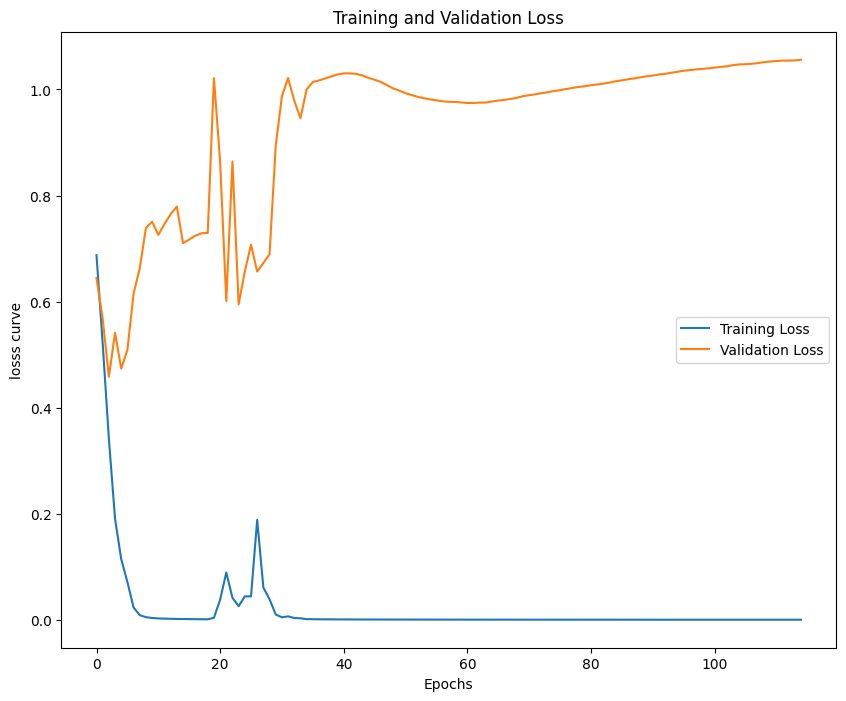

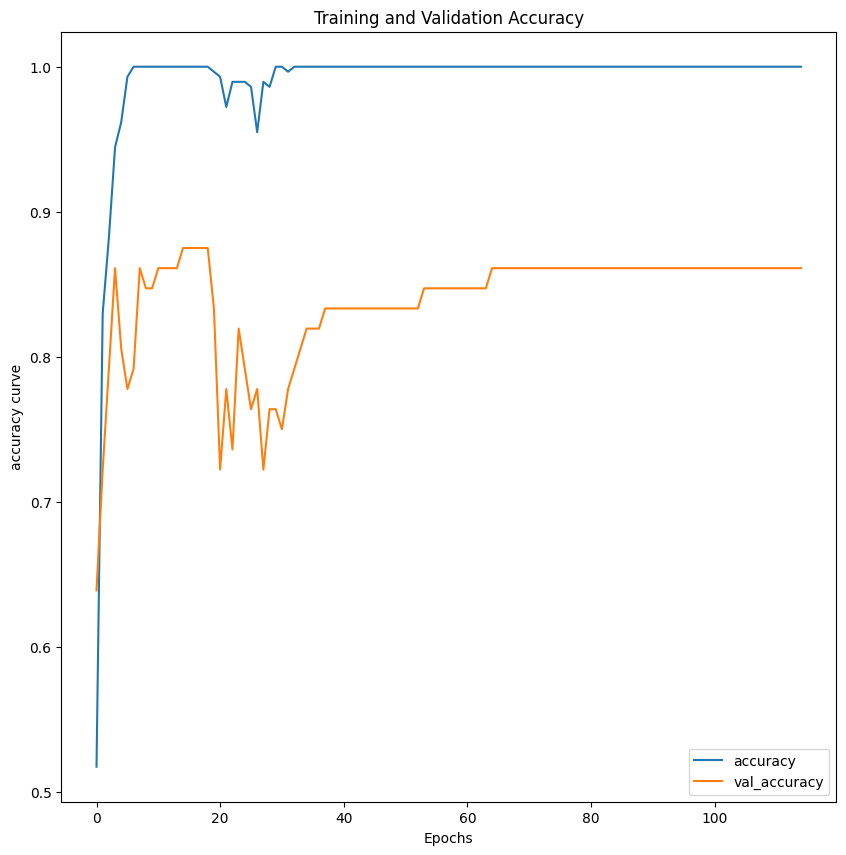

In [37]:
loss(history2)

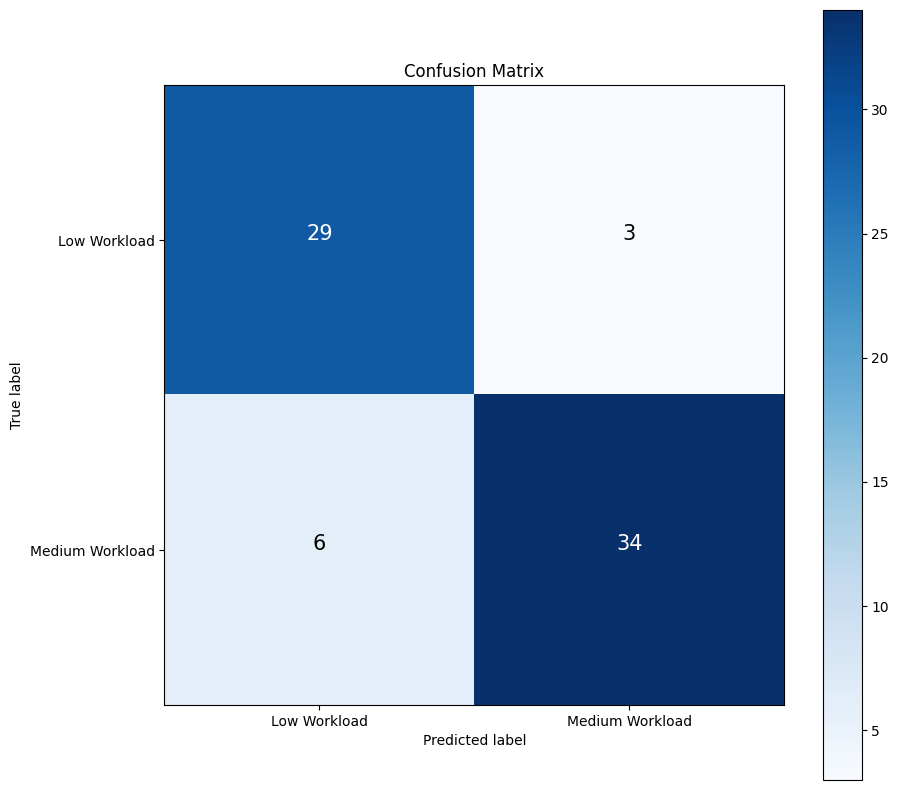

In [38]:
make_confusion_matrix(y_true=y_test,y_pred=y_pred,classes=classes)

In [39]:
clf_report=classification_report(y_pred=y_pred,y_true=y_test,
                                   output_dict=True,target_names=classes)
clf_report=pd.DataFrame(clf_report)
clf_report

,Low Workload,Medium Workload,accuracy,macro avg,weighted avg
precision,0.828571,0.918919,0.875,0.873745,0.878764
recall,0.906250,0.850000,0.875,0.878125,0.875000
f1-score,0.865672,0.883117,0.875,0.874394,0.875363
support,32.000000,40.000000,0.875,72.000000,72.000000


<AxesSubplot: >

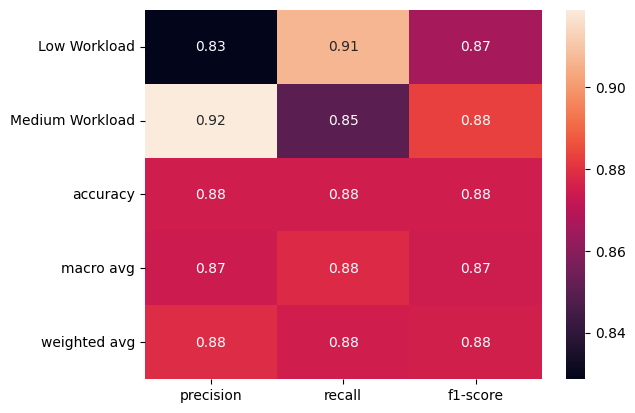

In [40]:
sns.heatmap(clf_report.iloc[:-1, :].T, annot=True)

Dense Model

In [41]:
accuracy_scores = []
f1_scores_list = []
recall_scores = []
precision_scores_list = []

crossvalidation = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in crossvalidation.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #1 model architecture

    input_layer=tf.keras.layers.Input(shape=(512,62,1),name="input_layer")
    Flattening_layer=tf.keras.layers.Flatten(name="Flattening_layer")(input_layer)
    Dense_layer_1=tf.keras.layers.Dense(32,activation="relu",name="Dense_layer_1")(Flattening_layer)
    Dense_layer_2=tf.keras.layers.Dense(64,activation="relu",name="Dense_layer_2")(Dense_layer_1)
    Dense_layer_3=tf.keras.layers.Dense(128,activation="relu")(Dense_layer_2)
    output_layer=tf.keras.layers.Dense(1,activation="sigmoid")(Dense_layer_3)
    dense_model=tf.keras.Model(inputs=input_layer,outputs=output_layer,name="dense_model")

    # 2 compile the model
    dense_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])


    # 3 fit the model
    history3=dense_model.fit(X_train, y_train, epochs=1000,validation_data=[X_test,y_test],
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=100,restore_best_weights=True),
    create_tensorboard_callback(dense_model.name,log)])

    # 4 evaluating our model
    y_pred = np.round(dense_model.predict(X_test))
    accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
    accuracy_scores.append(accuracy)
    f1 = f1_score_func(y_true=y_test, y_pred=y_pred, average='binary')
    f1_scores_list.append(f1)
    recall = recall_score(y_true=y_test, y_pred=y_pred, average='binary')
    recall_scores.append(recall)
    precision = precision_score(y_true=y_test, y_pred=y_pred, average='binary')
    precision_scores_list.append(precision)

mean_accuracy = np.mean(accuracy_scores)
mean_f1 = np.mean(f1_scores_list)
mean_recall = np.mean(recall_scores)
mean_precision = np.mean(precision_scores_list)

dense_model_score = {"Accuracy": mean_accuracy, "F1-Score": mean_f1, "Recall": mean_recall, "Precision": mean_precision}


Saving TensorBoard log files to: dense_model/tensorbord/20230329-194226
Epoch 1/1000
9/9 [==============================] - 1s 42ms/step - loss: 6.0229 - accuracy: 0.4965 - val_loss: 7.1085 - val_accuracy: 0.5139
Epoch 2/1000
9/9 [==============================] - 0s 14ms/step - loss: 6.0347 - accuracy: 0.5417 - val_loss: 4.9709 - val_accuracy: 0.5000
Epoch 3/1000
9/9 [==============================] - 0s 13ms/step - loss: 2.5839 - accuracy: 0.7708 - val_loss: 9.3031 - val_accuracy: 0.5139
Epoch 4/1000
9/9 [==============================] - 0s 14ms/step - loss: 3.4214 - accuracy: 0.7917 - val_loss: 10.5291 - val_accuracy: 0.5417
Epoch 5/1000
9/9 [==============================] - 0s 13ms/step - loss: 1.4778 - accuracy: 0.8646 - val_loss: 7.2018 - val_accuracy: 0.5278
Epoch 6/1000
9/9 [==============================] - 0s 14ms/step - loss: 1.5620 - accuracy: 0.8993 - val_loss: 8.2598 - val_accuracy: 0.5556
Epoch 7/1000
9/9 [==============================] - 0s 13ms/step - loss: 0.8914 -

In [42]:
mean_accuracy

0.6027777777777777

In [43]:
dense_model_score

{'Accuracy': 0.6027777777777777,
 'F1-Score': 0.5654220395995729,
 'Recall': 0.5355357142857143,
 'Precision': 0.6124801423621751}

In [44]:
dense_model.summary()

Model: "dense_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 512, 62, 1)]      0         
                                                                 
 Flattening_layer (Flatten)  (None, 31744)             0         
                                                                 
 Dense_layer_1 (Dense)       (None, 32)                1015840   
                                                                 
 Dense_layer_2 (Dense)       (None, 64)                2112      
                                                                 
 dense_18 (Dense)            (None, 128)               8320      
                                                                 
 dense_19 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,026,401
Trainable params: 1,026,401
Non

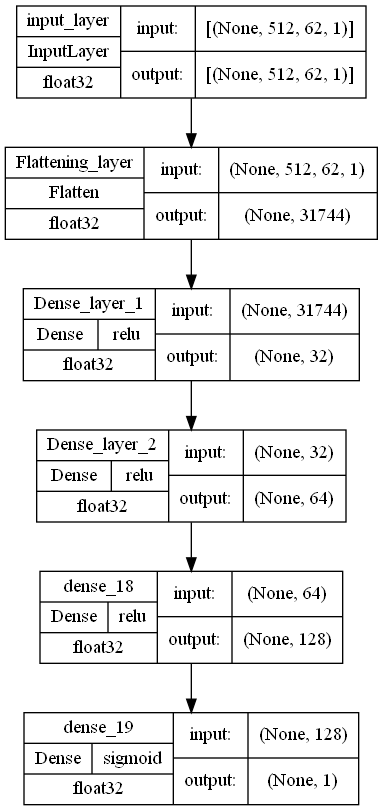

In [45]:
plot_model(dense_model,show_dtype=True,show_layer_activations=True,show_shapes=True)

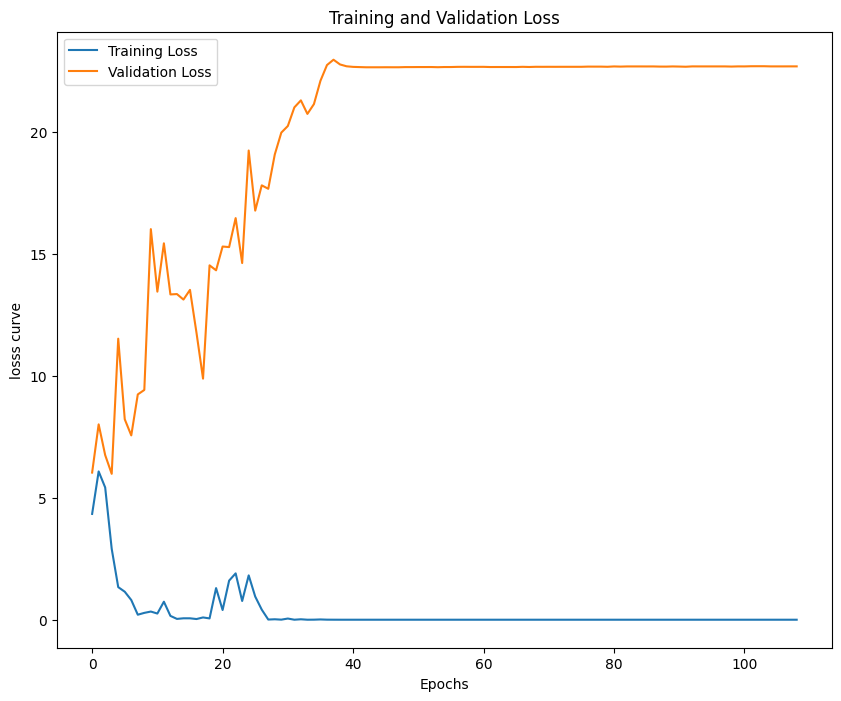

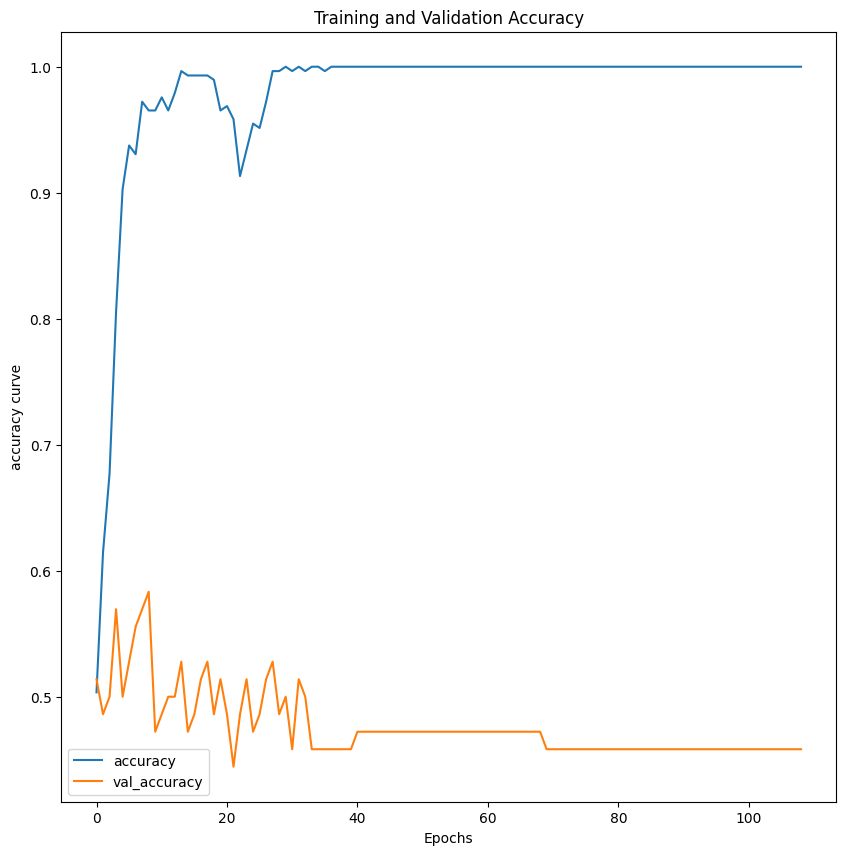

In [46]:
loss(history3)

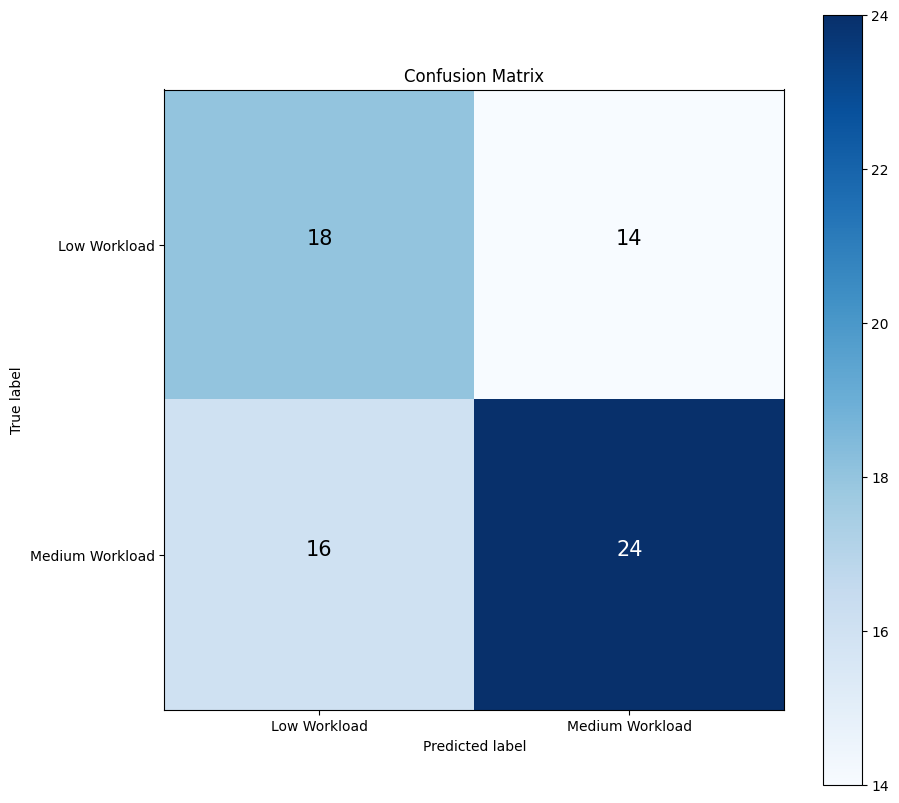

In [47]:
make_confusion_matrix(y_true=y_test,y_pred=y_pred,classes=classes)

In [48]:
clf_report=classification_report(y_pred=y_pred,y_true=y_test,
                                   output_dict=True,target_names=classes)
clf_report=pd.DataFrame(clf_report)
clf_report

,Low Workload,Medium Workload,accuracy,macro avg,weighted avg
precision,0.529412,0.631579,0.583333,0.580495,0.586171
recall,0.562500,0.600000,0.583333,0.581250,0.583333
f1-score,0.545455,0.615385,0.583333,0.580420,0.584305
support,32.000000,40.000000,0.583333,72.000000,72.000000


<AxesSubplot: >

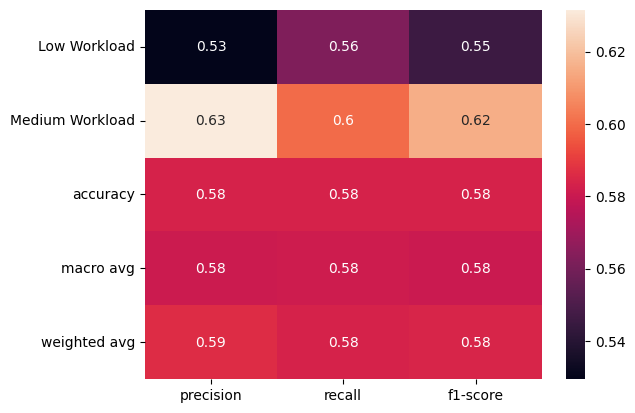

In [49]:
sns.heatmap(clf_report.iloc[:-1, :].T, annot=True)

Hybrid Model

In [50]:
accuracy_scores = []
f1_scores_list = []
recall_scores = []
precision_scores_list = []

crossvalidation = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in crossvalidation.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #1 model architecture

    input_layer_cnn=tf.keras.layers.Input(shape=(512,62,1),name="input_layer_cnn")
    conv_layer_1=tf.keras.layers.Convolution2D(filters=10,kernel_size=3,activation="relu",name="conv_layer_1")(input_layer_cnn)
    maxpooling_1=tf.keras.layers.MaxPooling2D(2,name="maxpooling_1")(conv_layer_1)
    conv_layer_2=tf.keras.layers.Convolution2D(10,3,activation="relu",name="conv_layer_2")(maxpooling_1)
    maxpooling_2=tf.keras.layers.MaxPooling2D(2,name="maxpooling_2")(conv_layer_2)
    flatten_layer=tf.keras.layers.Flatten(name="fatten_layer")(maxpooling_2)
    reshaped_input = tf.keras.layers.Reshape(target_shape=(512, 62))(input_layer_cnn)
    lstm_layer1=tf.keras.layers.LSTM(100,return_sequences=True,activation="tanh")(reshaped_input)
    lstm_layer2=tf.keras.layers.LSTM(100,activation="tanh")(lstm_layer1)
    merged=tf.keras.layers.Concatenate(name="merged_layer")([flatten_layer,lstm_layer2])
    batch_normalization1=tf.keras.layers.BatchNormalization(name="BatchNormalization_layer1")(merged)
    dense_Layer_1=tf.keras.layers.Dense(256,activation="relu",name="Dense_Layer_1")(batch_normalization1)
    drop1=tf.keras.layers.Dropout(0.1,name="dropout_layer_1")(dense_Layer_1)
    batch_normalization2=tf.keras.layers.BatchNormalization(name="BatchNormalization_layer2")(drop1)
    dense_Layer_2=tf.keras.layers.Dense(256,activation="relu",name="Dense_Layer_2")(batch_normalization2)
    drop2=tf.keras.layers.Dropout(0.1,name="dropout_layer_2")(dense_Layer_2)
    output_layer=tf.keras.layers.Dense(1,activation="sigmoid")(drop2)
    hybrid_model=tf.keras.models.Model(inputs = input_layer_cnn, outputs = output_layer,name="hybrid_model")

    # 2 compile the model

    hybrid_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])


    # 3 fit the model
    history4=hybrid_model.fit(X_train, y_train, epochs=1000,validation_data=[X_test,y_test],
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=50,restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=25,verbose=1),create_tensorboard_callback(hybrid_model.name,log)])

    # 4 evaluating our model
    y_pred = np.round(hybrid_model.predict(X_test))
    accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
    accuracy_scores.append(accuracy)
    f1 = f1_score_func(y_true=y_test, y_pred=y_pred, average='binary')
    f1_scores_list.append(f1)
    recall = recall_score(y_true=y_test, y_pred=y_pred, average='binary')
    recall_scores.append(recall)
    precision = precision_score(y_true=y_test, y_pred=y_pred, average='binary')
    precision_scores_list.append(precision)

mean_accuracy = np.mean(accuracy_scores)
mean_f1 = np.mean(f1_scores_list)
mean_recall = np.mean(recall_scores)
mean_precision = np.mean(precision_scores_list)

hybrid_model_score = {"Accuracy": mean_accuracy, "F1-Score": mean_f1, "Recall": mean_recall, "Precision": mean_precision}


Saving TensorBoard log files to: hybrid_model/tensorbord/20230329-194334
Epoch 1/1000
9/9 [==============================] - 6s 273ms/step - loss: 0.6616 - accuracy: 0.7257 - val_loss: 8.2804 - val_accuracy: 0.4861 - lr: 0.0010
Epoch 2/1000
9/9 [==============================] - 2s 170ms/step - loss: 0.1897 - accuracy: 0.9375 - val_loss: 0.8880 - val_accuracy: 0.7222 - lr: 0.0010
Epoch 3/1000
9/9 [==============================] - 2s 173ms/step - loss: 0.0722 - accuracy: 0.9826 - val_loss: 0.6031 - val_accuracy: 0.7361 - lr: 0.0010
Epoch 4/1000
9/9 [==============================] - 2s 173ms/step - loss: 0.0265 - accuracy: 1.0000 - val_loss: 0.6146 - val_accuracy: 0.6944 - lr: 0.0010
Epoch 5/1000
9/9 [==============================] - 2s 176ms/step - loss: 0.0190 - accuracy: 1.0000 - val_loss: 0.6021 - val_accuracy: 0.6944 - lr: 0.0010
Epoch 6/1000
9/9 [==============================] - 2s 175ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.5897 - val_accuracy: 0.7222 - lr: 0.00

In [51]:
accuracy_scores

[0.9861111111111112,
 0.8611111111111112,
 0.9305555555555556,
 0.9861111111111112,
 0.9027777777777778]

In [52]:
mean_accuracy

0.9333333333333333

In [53]:
hybrid_model_score

{'Accuracy': 0.9333333333333333,
 'F1-Score': 0.933556618526713,
 'Recall': 0.9191259398496241,
 'Precision': 0.9493479193479193}

In [54]:
hybrid_model.summary()

Model: "hybrid_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer_cnn (InputLayer)   [(None, 512, 62, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv_layer_1 (Conv2D)          (None, 510, 60, 10)  100         ['input_layer_cnn[0][0]']        
                                                                                                  
 maxpooling_1 (MaxPooling2D)    (None, 255, 30, 10)  0           ['conv_layer_1[0][0]']           
                                                                                                  
 conv_layer_2 (Conv2D)          (None, 253, 28, 10)  910         ['maxpooling_1[0][0]']

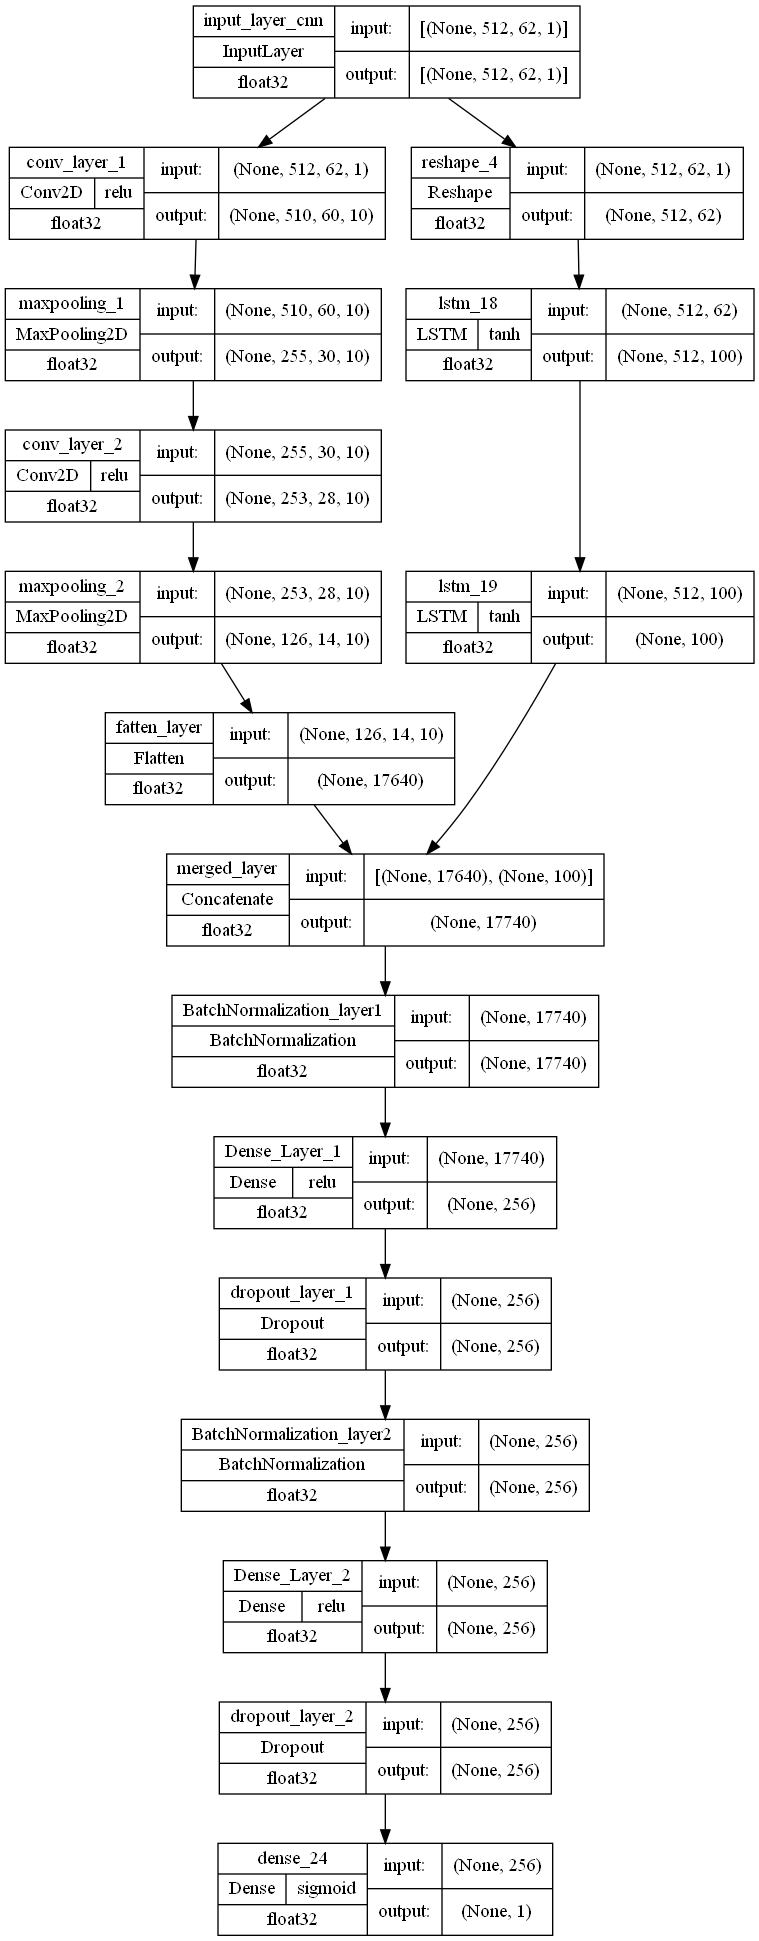

In [55]:
plot_model(hybrid_model,show_dtype=True,show_layer_activations=True,show_shapes=True)

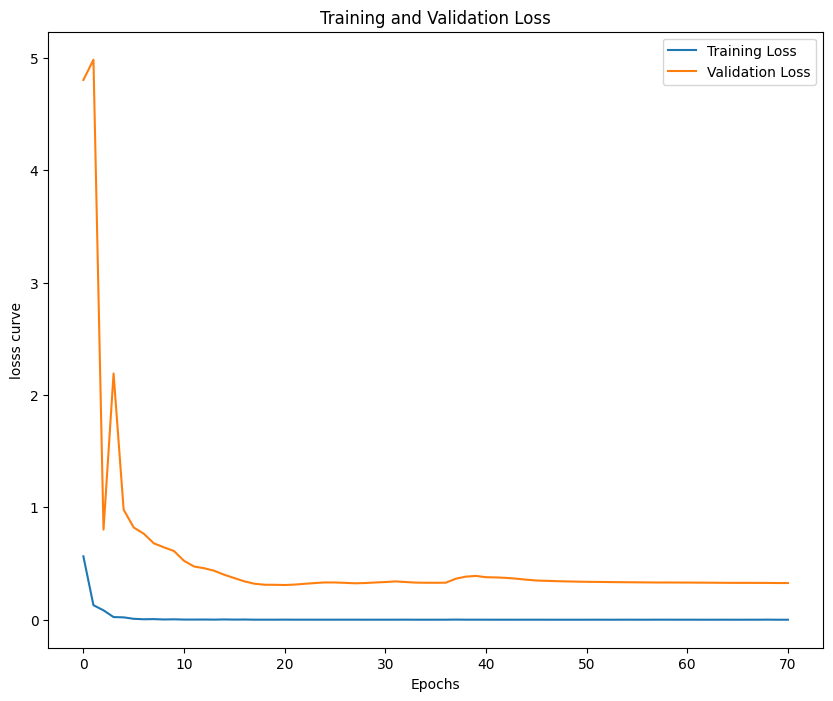

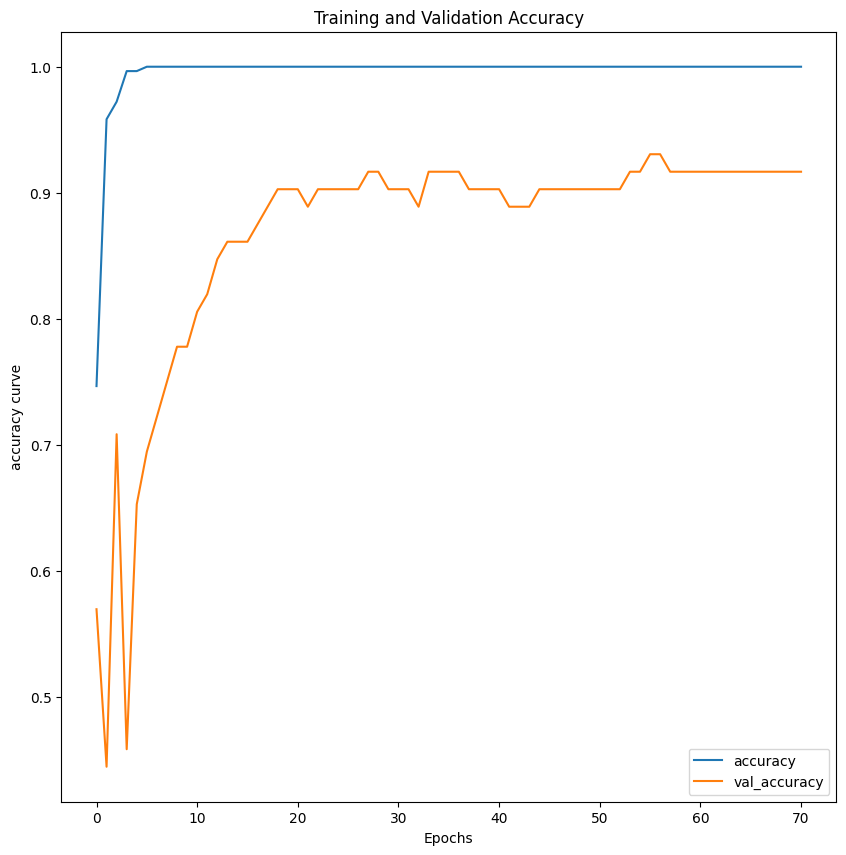

In [56]:
loss(history4)

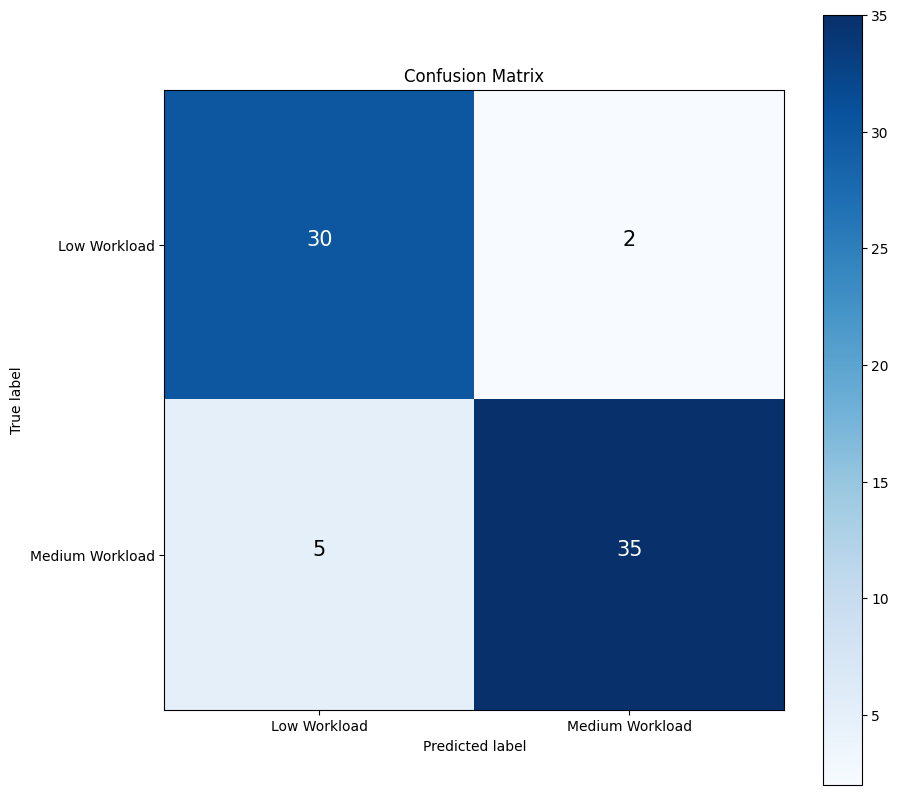

In [57]:
make_confusion_matrix(y_true=y_test,y_pred=y_pred,classes=classes)

In [58]:
clf_report=classification_report(y_pred=y_pred,y_true=y_test,
                                   output_dict=True,target_names=classes)
clf_report=pd.DataFrame(clf_report)
clf_report

,Low Workload,Medium Workload,accuracy,macro avg,weighted avg
precision,0.857143,0.945946,0.902778,0.901544,0.906478
recall,0.937500,0.875000,0.902778,0.906250,0.902778
f1-score,0.895522,0.909091,0.902778,0.902307,0.903060
support,32.000000,40.000000,0.902778,72.000000,72.000000


<AxesSubplot: >

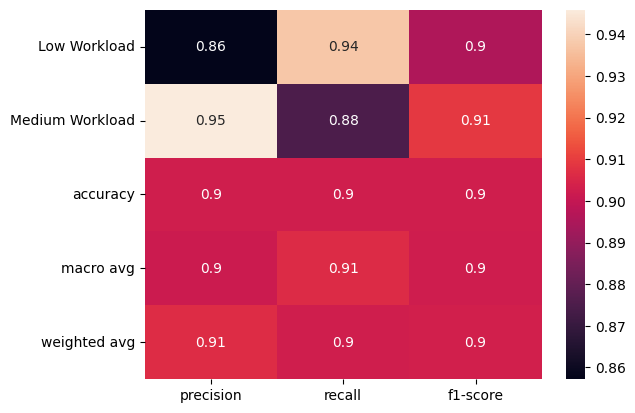

In [59]:
sns.heatmap(clf_report.iloc[:-1, :].T, annot=True)

Comparing the results

In [60]:
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


In [61]:
score={"Logistic Model":log_model_score,"Cnn Model":cnn_model_score,"LSTM Model":lstm_model_score,"Dense Model":dense_model_score,"Hybrid Model(lstm+cnn)":hybrid_model_score}

In [62]:
score

{'Logistic Model': {'Accuracy': 0.5055555555555555,
  'F1-Score': 0.5682325896092932,
  'Recall': 0.6522086466165413,
  'Precision': 0.5087738670347366},
 'Cnn Model': {'Accuracy': 0.9111111111111111,
  'F1-Score': 0.9083954203691045,
  'Recall': 0.8797556390977442,
  'Precision': 0.9404604529984036},
 'LSTM Model': {'Accuracy': 0.8944444444444443,
  'F1-Score': 0.895769968593498,
  'Recall': 0.9040507518796993,
  'Precision': 0.8919303757539051},
 'Dense Model': {'Accuracy': 0.6027777777777777,
  'F1-Score': 0.5654220395995729,
  'Recall': 0.5355357142857143,
  'Precision': 0.6124801423621751},
 'Hybrid Model(lstm+cnn)': {'Accuracy': 0.9333333333333333,
  'F1-Score': 0.933556618526713,
  'Recall': 0.9191259398496241,
  'Precision': 0.9493479193479193}}

In [63]:
score=pd.DataFrame.from_dict(score, orient='index')

In [64]:
highlighted_score = score.style.highlight_max(color="blue").highlight_min(color="red")
highlighted_score.set_caption("Lowest values in red, highest values in blue")
display(highlighted_score)

highlighted_df = score.style.highlight_max(color='blue').highlight_min(color='red')
cm = sns.diverging_palette(10, 220, sep=80, n=7, as_cmap=True)
highlighted_df.background_gradient(cmap=cm).set_caption("Lowest values in red, highest values in blue")


,Accuracy,F1-Score,Recall,Precision
Logistic Model,0.505556,0.568233,0.652209,0.508774
Cnn Model,0.911111,0.908395,0.879756,0.940460
LSTM Model,0.894444,0.895770,0.904051,0.891930
Dense Model,0.602778,0.565422,0.535536,0.612480
Hybrid Model(lstm+cnn),0.933333,0.933557,0.919126,0.949348


,Accuracy,F1-Score,Recall,Precision
Logistic Model,0.505556,0.568233,0.652209,0.508774
Cnn Model,0.911111,0.908395,0.879756,0.940460
LSTM Model,0.894444,0.895770,0.904051,0.891930
Dense Model,0.602778,0.565422,0.535536,0.612480
Hybrid Model(lstm+cnn),0.933333,0.933557,0.919126,0.949348


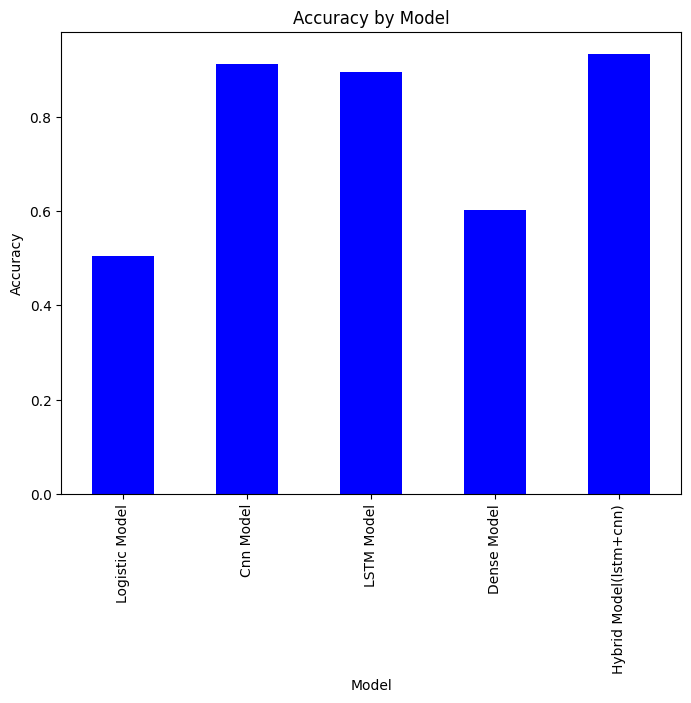

In [65]:
ax = score['Accuracy'].plot(kind='bar', figsize=(8,6), color='blue')
ax.set_title('Accuracy by Model')
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
plt.show()


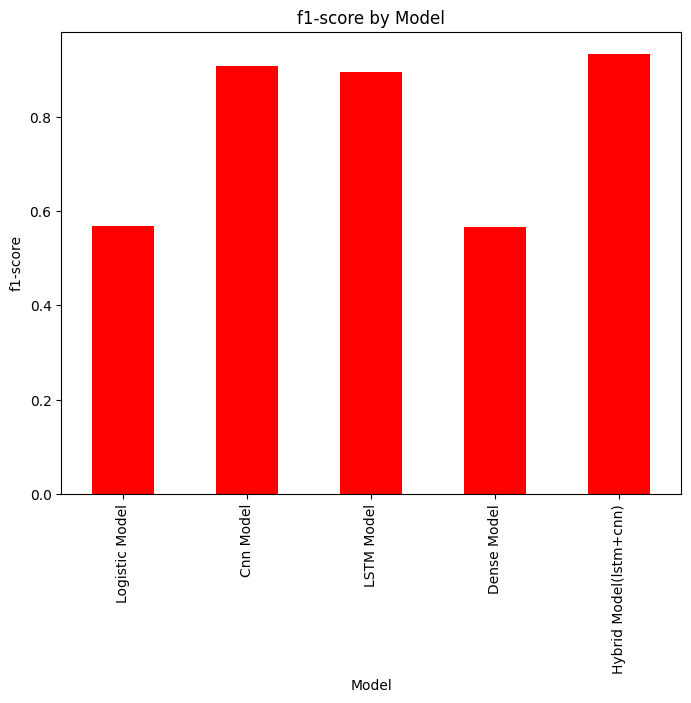

In [67]:
ax = score['F1-Score'].plot(kind='bar', figsize=(8,6), color='red')
ax.set_title('f1-score by Model')
ax.set_xlabel('Model')
ax.set_ylabel('f1-score')
plt.show()


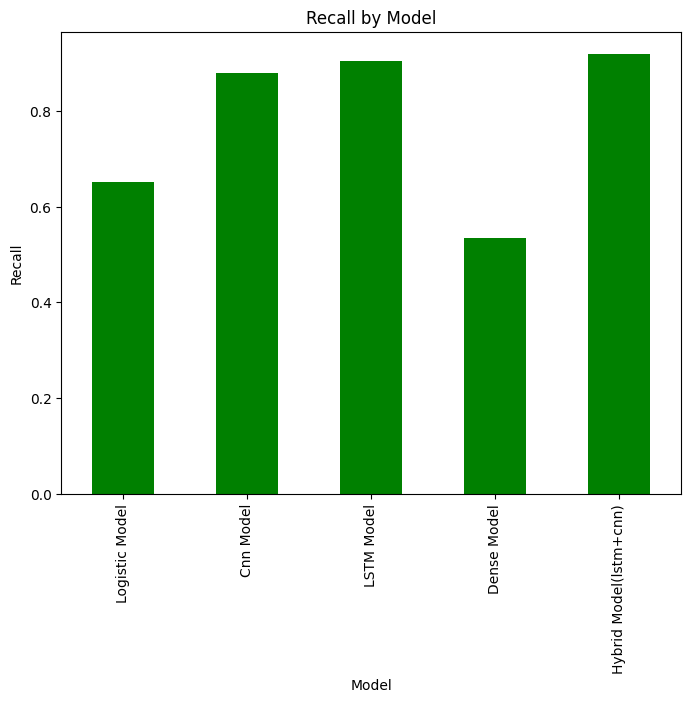

In [68]:
ax = score['Recall'].plot(kind='bar', figsize=(8,6), color='green')
ax.set_title('Recall by Model')
ax.set_xlabel('Model')
ax.set_ylabel('Recall')
plt.show()


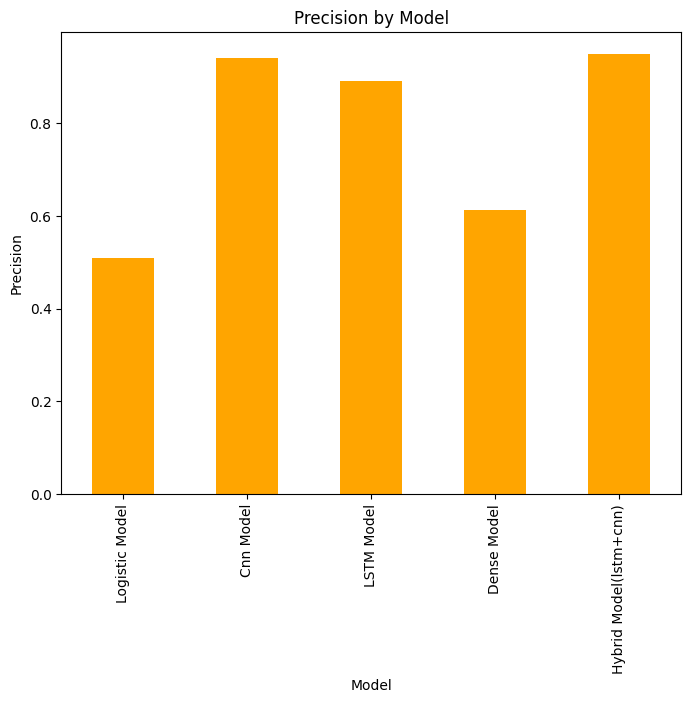

In [69]:
ax = score['Precision'].plot(kind='bar', figsize=(8,6), color='orange')
ax.set_title('Precision by Model')
ax.set_xlabel('Model')
ax.set_ylabel('Precision')
plt.show()
